In [9]:
import re
import numpy as np
import pandas as pd
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from sklearn.cluster import DBSCAN
import datetime
import time
import seaborn as sns
"""from dask.distributed import Client
from dask_ml import preprocessing
import dask.dataframe as dd
import dask.array as da"""

states = ["INITIAL","login","View_Items","home","logout","View_Items_quantity","Add_to_Cart","shoppingcart",
          "remove","deferorder","purchasecart","inventory","sellinventory","clearcart","cancelorder","$"]

#Data imports
PATH = "../../data/raw/"
sessions_file = (PATH+'sessions.dat')

In [2]:
def session_request_dict(sessions_file):
    s_r_dict = {}
    # Dict of sessions
    with open(sessions_file) as fn:
        sessions_raw = fn.readlines()

    for session in sessions_raw:
        key = re.search('([^.]+)', session).group()
        value = re.findall('\"(.*?)\"', session)
        s_r_dict[key] = value

    return s_r_dict

In [3]:
def transition_matrix(sessions, states):
    markovchains = []

    for key, value in sessions.items():
        # labelEncoding
        le = preprocessing.LabelEncoder()
        le.fit(value)
        le.transform(value)

        # factorize
        factorize = pd.factorize(value)[0]
        
        # matrix
        n = 1 + max(factorize)  # number of states
        m = [[0] * n for _ in range(n)]

        for (i, j) in zip(factorize, factorize[1:]):
            m[i][j] += 1

        # now convert to probabilities:
        for row in m:
            s = sum(row)
            if s > 0:
                row[:] = [f / s for f in row]

        # unique array in the right order
        value = np.array(value)
        _, idx = np.unique(value, return_index=True)

        df = pd.DataFrame(data=m, index=value[np.sort(idx)],
                          columns=value[np.sort(idx)])

        df_1 = pd.DataFrame(index=states, columns=states, dtype='float64')
        df_1.update(df, join='left')

        merge = pd.concat([pd.concat([df_1, df], axis=1, sort=False)], axis=0).fillna(0).round(2).iloc[:, :-n]

        # convert into Vector
        merge = np.array(merge.values.flatten().tolist())
        # 2-D array
        markovchains.append(merge)
        # csr sparse matrix
        csr = csr_matrix(markovchains)

    return csr


In [ ]:
def dbscan_model():
    

In [25]:
%%time

data = session_request_dict(sessions_file)
print(len(data))
set_1 = {k: data[k] for k in list(data)[:100]}
set_2 = {k: data[k] for k in list(data)[500:600]}
print('load data done', datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))
#for X in tqdm(range(len(small_data_set))):
X = transition_matrix(set_2, states)
print('matrix done', datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S \n'))
print('start clustering')
clustering = DBSCAN(eps=1.5, min_samples=10).fit(X)
labels = clustering.labels_
#print(labels)
print(np.unique(labels, return_counts=True))
print(clustering)
print(labels)
print("End clustering", datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

30927
load data done 2019-05-20 17:02:15
matrix done 2019-05-20 17:02:17 

start clustering
(array([-1,  0,  1,  2], dtype=int64), array([ 2, 28, 46, 24], dtype=int64))
DBSCAN(algorithm='auto', eps=1.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=None, p=None)
[-1  0  1  1  0  1  1  1  2  0  1  1  0  0  1  0  1  0  2  1  0  2  0  1
  0  0  1  2  1  1  1  2  1  1  0  2  1  1  1  0  2  0  1  2  2  0  0  1
  1  0  1  2  0  2  2  2  1  1  0  1  1  2  2  2  1  1  0  2  2  0  1  1
  0  2 -1  0  2  1  0  0  1  1  1  2  2  0  1  1  1  0  1  0  2  1  1  1
  1  1  1  2]
End clustering 2019-05-20 17:02:17
Wall time: 3.35 s


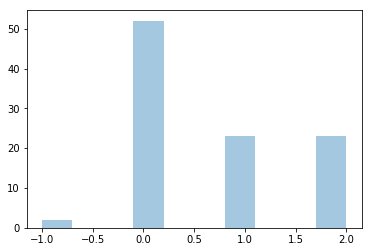

In [24]:
sns.distplot(labels, bins=10,kde=False)

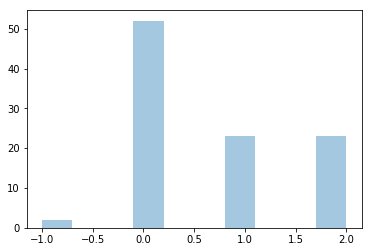

In [26]:
sns.distplot(labels, bins=10,kde=False)